In [ ]:
!pip install nltk
!pip3 install tqdm


In [ ]:
import os
import pandas as pd
import numpy as np
import nltk
import pickle
import tensorflow as tf
import gensim
import matplotlib.pyplot as plt
from os import path
from tqdm import tqdm
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras import preprocessing
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout, Embedding, LSTM, add
from keras.utils import to_categorical

nltk.download("stopwords")
stop_words = set(stopwords.words('english'))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Num GPUs Available:  0


In [ ]:
# comment it out if working on local machine. Only required when using google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
CAPTION_FILE_PATH = "captions.txt"
IMAGE_FOLDER_PATH = "Images"
IMAGE_PICKLE = "image_pickle.p"
W2V_PICKLE_PATH = "w2v_embeddings.p"


In [ ]:
df = pd.read_csv(CAPTION_FILE_PATH)

In [ ]:
images = df.iloc[:, 0]
captions = df.iloc[:, 1]
print(images.shape)
print(captions.shape)

(40455,)
(40455,)


In [ ]:
print("images>>>>")
print(images[0:10])
print("captions>>>>>")
print(captions[0:10])

images>>>>
0    1000268201_693b08cb0e.jpg
1    1000268201_693b08cb0e.jpg
2    1000268201_693b08cb0e.jpg
3    1000268201_693b08cb0e.jpg
4    1000268201_693b08cb0e.jpg
5    1001773457_577c3a7d70.jpg
6    1001773457_577c3a7d70.jpg
7    1001773457_577c3a7d70.jpg
8    1001773457_577c3a7d70.jpg
9    1001773457_577c3a7d70.jpg
Name: image, dtype: object
captions>>>>>
0    A child in a pink dress is climbing up a set o...
1                A girl going into a wooden building .
2     A little girl climbing into a wooden playhouse .
3    A little girl climbing the stairs to her playh...
4    A little girl in a pink dress going into a woo...
5           A black dog and a spotted dog are fighting
6    A black dog and a tri-colored dog playing with...
7    A black dog and a white dog with brown spots a...
8    Two dogs of different breeds looking at each o...
9      Two dogs on pavement moving toward each other .
Name: caption, dtype: object


In [ ]:
#### preprocess the captions #######
for i, caption in enumerate(captions):
    _caption = caption.lower()
    tokens = _caption.split()
    tokens = [word for word in tokens if not word in stop_words]
    # remove tokens with numbers in them
    tokens = [word for word in tokens if word.isalpha()]
    #Add start and end sequence tokens
    captions[i] = "<start> " + " ".join(tokens) + " <end>"


print(captions[0:5])

0    <start> child pink dress climbing set stairs e...
1             <start> girl going wooden building <end>
2    <start> little girl climbing wooden playhouse ...
3    <start> little girl climbing stairs playhouse ...
4    <start> little girl pink dress going wooden ca...
Name: caption, dtype: object


In [ ]:
train_x, test_x, train_y, test_y = train_test_split(images, captions, random_state=0)
print(train_x[0:5])
print(train_y[0:5])

15051    2817847072_5eb3bc30ac.jpg
34989    3717309680_e5105afa6d.jpg
40193     948196883_e190a483b1.jpg
8383     2380765956_6313d8cae3.jpg
26099    3351667846_ac43118ae5.jpg
Name: image, dtype: object
15051       <start> boy soccer uniform running field <end>
34989     <start> four motorcycles racing dirt track <end>
40193    <start> man brwon jacket shoulders lying sidew...
8383     <start> girl green blue jacket walking past en...
26099                <start> people line plates rice <end>
Name: caption, dtype: object


In [ ]:
#### Create a vocabulary from the train captions in train_y #####
#Eliminate infrequently occurring words from the vocabulary

vocabulary = set()
word_counts = {}

for caption in train_y:
    tokens = caption.split(" ")
    for token in tokens:
        vocabulary.add(token)
        if token in word_counts:
            word_counts[token] += 1
        else:
            word_counts[token] = 1

core_vocab = [key for key in word_counts if word_counts[key] >= 2]

In [ ]:
#### create a list of captions corresponding to a particular image ######


def create_image_to_caption_dict(images,captions):
  image_to_caption = defaultdict(list)
  for img_, caption in zip(images, captions):
    _image = img_.replace(".jpg", "").strip()
    image_to_caption[_image].append(caption)
  return image_to_caption

train_image_to_caption = create_image_to_caption_dict(train_x, train_y)
test_image_to_caption = create_image_to_caption_dict(test_x, test_y)




In [ ]:
model = InceptionV3(weights="imagenet")
model = Model(model.input, model.layers[-2].output)

96116736/96112376 [==============================] - 1s 0us/step


In [ ]:
# Convert all the images to size 299x299 as expected by the

def encode_images(x):
  encoded_images = {}
  
  for _x in tqdm(x):
    image_path = path.join(IMAGE_FOLDER_PATH, _x)
    img = image.load_img(image_path, target_size=(299, 299))
    X = image.img_to_array(img)
    X = np.expand_dims(X, axis=0)
    X = preprocess_input(X)
    features = model.predict(X)
    X = np.reshape(features, features.shape[1])
    encoded_images[_x] = X
  return encoded_images




In [ ]:
encoded_images = {}


if os.path.isfile(IMAGE_PICKLE):
    with open(IMAGE_PICKLE, 'rb') as p:
        encoded_images = pickle.load(p)
else: 
    encoded_images = encode_images(set(images))
    pickle.dump(encoded_images, open("image_pickle.p", "wb"))



In [ ]:
#Create python dictionaries to encode indices of unique words in vocabulary
w2idx = {core_vocab[i]: i for i in range(len(core_vocab))}
idx2w = {i: core_vocab[i] for i in range(len(core_vocab))}

In [ ]:
#Get max caption length
max_caption_length = max(len(i.split(' ')) for i in captions)
print(max_caption_length)

22


In [ ]:
#Create dictionary of word embeddings for full vocabulary
# w2v_model = KeyedVectors.load_word2vec_format("glove.6B.200d.txt", binary=False)
# embedding_dict = {i: w2v_model[i] for i in core_vocab if i in w2v_model}
# pickle.dump(embedding_dict, open("w2v_embeddings.p", "wb"))

embedding_dict = {}
with open(W2V_PICKLE_PATH, 'rb') as p:
  embedding_dict = pickle.load(p)

In [ ]:
#Create matrix of word embeddings
emb_dimensions = 200

word_embeddings = np.zeros((len(core_vocab), emb_dimensions))

for word, index in w2idx.items():
    if word in embedding_dict:
        word_embeddings[index] = embedding_dict[word]


In [ ]:
#Create merge architecture model
image_inputs = Input(shape=(2048,), name="ImageLayer")
image_layer1 = Dropout(0.2)(image_inputs)
image_layer2 = Dense(256, activation = 'relu')(image_layer1)

caption_inputs = Input(shape = (max_caption_length,), name="CaptionLayer")
caption_layer1 = Embedding(len(core_vocab), emb_dimensions, mask_zero = True)(caption_inputs)
caption_layer2 = Dropout(0.5)(caption_layer1)
caption_layer3 = LSTM(256)(caption_layer2)

decoder_layer1 = add([image_layer2, caption_layer3])
decoder_layer2 = Dense(256, activation = 'relu')(decoder_layer1)
output = Dense(len(core_vocab), activation = 'softmax')(decoder_layer2)

model2 = Model(inputs = [image_inputs, caption_inputs], outputs = output)
model2.layers[2].set_weights([word_embeddings])
model2.layers[2].trainable = False

model2.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

In [ ]:
print(model2.summary())


Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
CaptionLayer (InputLayer)       [(None, 22)]         0                                            
__________________________________________________________________________________________________
ImageLayer (InputLayer)         [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 22, 200)      881800      CaptionLayer[0][0]               
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           ImageLayer[0][0]                 
_______________________________________________________________________________________

In [ ]:
def generate_data(caption_dict, images, w2idx, max_len, batch_size):
    image_sequence, input_words, output_words = [], [], []
    n = 0
    while True:
        for img_name, caption_list in caption_dict.items():
            n += 1
            photo = images[img_name + ".jpg"]
            for c in caption_list:
              # encode the words in caption using word to index dictionary  
              encoded_caption = [w2idx[w] for w in c.split(" ") if w in w2idx]

              for i in range(1, len(encoded_caption)):
                # input sequence should be upto an index, output should be the index
                input_sequence, output_sequence = encoded_caption[:i], encoded_caption[i]
                # pad the input sequence to the same number of tokens
                input_sequence = pad_sequences([input_sequence], maxlen= max_len)[0]

                # encode the ouput sequence as categorical class
                output_sequence = to_categorical([output_sequence], num_classes=len(core_vocab))[0]

                image_sequence.append(photo)
                input_words.append(input_sequence)
                output_words.append(output_sequence)

            if n == batch_size:
              yield([np.array(image_sequence), np.array(input_words)], np.array(output_words))
              image_sequence, input_words, output_words = [], [], []
              n = 0

In [ ]:
num_epochs = 10
batch_size = 64
num_steps = len(train_x) // batch_size
# print(num_steps)

for i in range(num_epochs):
    print("---------------------")
    print("epoch", i)
    data_generator = generate_data(train_image_to_caption, encoded_images, w2idx, max_caption_length, batch_size)
    model2.fit(data_generator, epochs = 1, steps_per_epoch = num_steps)
    model2.save('model_epoch_' + str(i) + '.h5')

---------------------
epoch 0
474/474 [==============================] - 72s 151ms/step - loss: 4.6937
---------------------
epoch 1
474/474 [==============================] - 73s 153ms/step - loss: 3.7646
---------------------
epoch 2
474/474 [==============================] - 72s 151ms/step - loss: 3.4039
---------------------
epoch 3
474/474 [==============================] - 72s 152ms/step - loss: 3.1585
---------------------
epoch 4
474/474 [==============================] - 73s 155ms/step - loss: 2.9798
---------------------
epoch 5
474/474 [==============================] - 74s 155ms/step - loss: 2.8511
---------------------
epoch 6
474/474 [==============================] - 72s 152ms/step - loss: 2.7340
---------------------
epoch 7
474/474 [==============================] - 73s 154ms/step - loss: 2.6291
---------------------
epoch 8
474/474 [==============================] - 73s 153ms/step - loss: 2.5544
---------------------
epoch 9
474/474 [==============================] - 

In [ ]:
# load model weights
model2.load_weights('model_epoch_9.h5',by_name=True)




In [ ]:
def predict(photo):
    start = '<start>'
    for i in range(max_caption_length):
        sequence = [w2idx[w] for w in start.split() if w in w2idx]
        sequence = pad_sequences([sequence], maxlen=max_caption_length)
        yhat = model2.predict([photo,sequence], verbose=1) 
        yhat = np.argmax(yhat)
        word = idx2w[yhat]
        start += ' ' + word
        if word == '<end>':
            break
    final = start.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

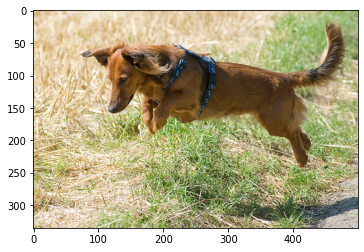

1/1 [==============================] - 0s 1ms/step
two dogs running field


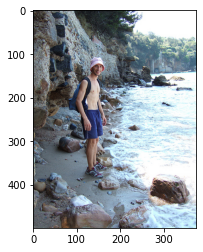

1/1 [==============================] - 0s 1ms/step
man wearing hat hat standing rock water


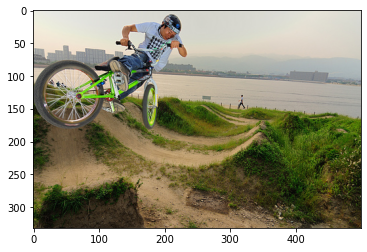

1/1 [==============================] - 0s 1ms/step
person riding bike dirt bike dirt course


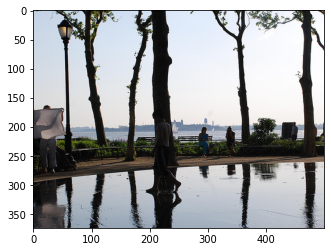

1/1 [==============================] - 0s 1ms/step
three people sit water fishing city


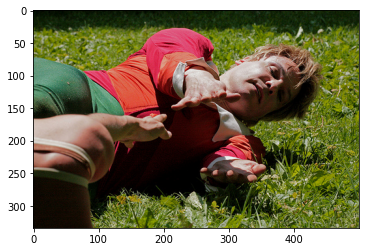

1/1 [==============================] - 0s 1ms/step
two boys lying grass


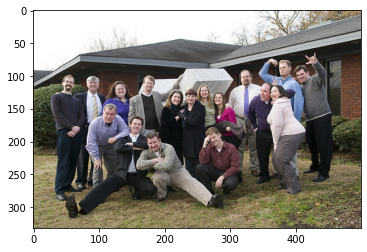

1/1 [==============================] - 0s 1ms/step
four people dressed black jackets sit outside outside


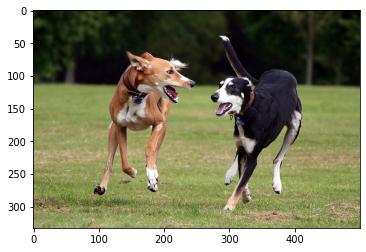

1/1 [==============================] - 0s 1ms/step
two dogs running field


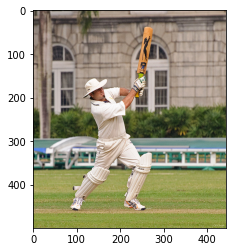

1/1 [==============================] - 0s 2ms/step
cricketer cricketer field


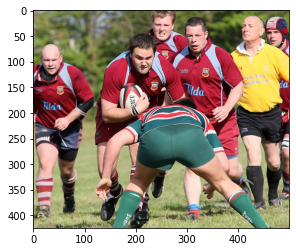

1/1 [==============================] - 0s 1ms/step
two men playing rugby


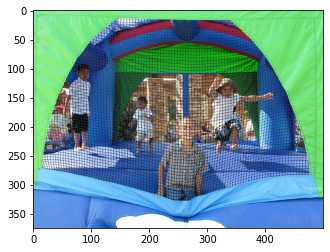

1/1 [==============================] - 0s 1ms/step
two children bed sprayed


In [ ]:
for i in range(10):
  pic = list(test_image_to_caption.keys())[i]
  image = encoded_images[pic + ".jpg"].reshape((1,2048))
  x=plt.imread(IMAGE_FOLDER_PATH + "/" + pic + ".jpg")
  plt.imshow(x)
  plt.show()
  print(predict(image))